<center style><h1>Computer Assignment 3</h1></center>
<center style><h1>Naive Bayes Classification</h1></center>

**In this assignment we are about to analyze some *divar.ir* ads and predict each ad category using naive bayes
classifier.**

We have ads in Vehicles, Electronic Devices, Business, For the Home, Personal, and Leisure & Hobbies.

## PreProcess

We will use *hazm* library to process persian text in our dataset.

In this preprocess we remove stop words and punctuation then use *hazm* to normalize and adjust spaces on title and
description. Then we divide sentences into words and find word root, so we can process them independently.

1 - In our text we might see a word in different forms, but they are from same root and can have same effect in our
classification. Stemming will remove prefix and postfix of a word to find it's root, but Lemmatization except removing
postfix and prefix of word, it will verify that root to be correct in meaning.

In our case Lemmatization has better performance and increase accuracy.

In [1]:
import pandas
from hazm import *

vehicle_frequency = {}
electronic_frequency = {}
business_frequency = {}
home_frequency = {}
personal_frequency = {}
hobbies_frequency = {}

category = ['vehicles', 'electronic-devices', 'businesses', 'for-the-home', 'personal', 'leisure-hobbies']
frequency = [vehicle_frequency, electronic_frequency, business_frequency, home_frequency, personal_frequency,
             hobbies_frequency]
stop_word = (stopwords_list() + ['.', '،', '؛', '[', ']', '{', '}', '(', ')', '?', '!', ':', '\"', '\'', '*', '/', '+',
                                 '%', '#','-', '_', '\r\n', '\n', '«', '»', '۹', '۸', '۷', '۶', '۵', '۴', '۳', '۲', '۱',
								 '۰'])

train_data = pandas.read_csv('Data/divar_train.csv')
test_data = pandas.read_csv('Data/divar_test.csv')

normalizer = Normalizer()
lemmatizer = Lemmatizer()
tokenizer = WordTokenizer()

def text_pre_process(sentence):
    text = normalizer.normalize(sentence)
    text = tokenizer.tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in text if not (word in stop_word)]
    return words

def pre_process(data):
    for i in range(len(data)):
        data['title'][i] = text_pre_process(data['title'][i])
        data['description'][i] = text_pre_process(data['description'][i])
    return data


train_data = pre_process(train_data)
train_data

,title,description,categories
0,"[بلبل, خرما]","[عدد, بلبل, خرما, ماهه, جوجه, خودم, بزرگشون, د...",leisure-hobbies
1,"[عینک, اسکی]","[عینک, اسکی, دبل, لنز, مارک, یو, وکس, نو, اصل,...",leisure-hobbies
2,"[تکیه, سر, تویوتا, پرادو]","[پارچه, سالم, تمیز]",vehicles
3,"[مجسمه, کریستال, ۲۴, ٪]","[مجسمه, دکوری, کریستال, بالرین, Rcr, ۲۴, ٪]",for-the-home
4,"[کیف, ساک]",[تمیز],personal
...,...,...,...
10195,"[ان, هاش, ۸۵]","[چی, شرط, خشک, ۲۶۰, کار]",vehicles
10196,"[۴۰۵, دوگانه, کارخانه, تمیز]","[فابریک, حلقه, لاستیک, ۲۰۵, نو, بیمه, یکسال, ت...",vehicles
10197,"[بخاری, گازی, دودکش, پلار]","[بخاری, نو, تمیز, هستش, مشتری, واقعی, میام]",for-the-home
10198,"[نر, کله, برنجی, چتر]","[سلام, دلیل, کمبود, واسباب, کشید#کش, کمترین, ق...",leisure-hobbies


In [2]:
test = pre_process(test_data)
test

,title,description,categories
0,"[کیف, مجلس, نو]","[کیف, مجلس, نو, نو]",personal
1,"[دیوار, کوب, نمد, تزیین]","[جهاز, عروس]",for-the-home
2,"[تیکه, تمیز, سالم]","[کشو, مخفی, شیک]",for-the-home
3,[مودم],"[سلام, مودم, سالم, وسایل, دیگه, ب, کاشت#کار, ن...",electronic-devices
4,"[۱۸, عددبوقلمون, قیمت, عمده]","[سلام, تعدای, بوقلمون, داشت#دار, جابه, فروش, ج...",leisure-hobbies
...,...,...,...
1795,"[باسکول, ۳۰۰, کیلویی]","[سالمه, سالمه, بشرط, قیمت, نوش, داخل, بازار, ۶...",businesses
1796,"[میز, مدیریت, کنفرانس]","[میز, مدیریت, کنفرانس, تمیز, سالم, خط, خش]",businesses
1797,"[باند, aiwa]","[سالم, اسپیکر]",electronic-devices
1798,"[عروس, هلند, مولد]","[عروس, هلند, جفت, ویک, تک, یه, جفت, دم, تخمه, ...",leisure-hobbies


## Process

We use bag of word method for title and description separately to count words related to category.

In classifier function we calculate probability of being in a class of each row. In this way, according to Bayes rule,
we obtain the probability of each word from the columns, provided that they belong to the desired class, and multiply them.

2 -
* Evidence : By seeing evidence we want to calculate posterior probability.
* Likelihood : Probability of having evidence in category c.
* Prior : Probability of having category c in all rows of dataset.
* Posterior : Probability of belonging word w to category c. We use this probability to classify.

In [3]:
d = 0

def word_frequency(words, freq_dict):
    for word in words:
        if not (word in freq_dict):
            freq_dict[word] = 1
            global d
            d += 1
        else:
            freq_dict[word] += 1
    return freq_dict

def calculate_frequency(train):
    for i in range(len(frequency)):
        for title in train.loc[train['categories'] == category[i], 'title']:
            frequency[i] = word_frequency(title, frequency[i])

        for description in train.loc[train['categories'] == category[i], 'description']:
            frequency[i] = word_frequency(description, frequency[i])

### Bigrams

3 -
* شیر حیوان درنده ای است

* شیر نوشیدنی مقوی است

In above examples the word 'شیر' is the same but with different meanings. With bigram and just by reading next word we
can determine which 'شیر' do we mean. In this example we don't need more than bigram, if not, we need n-gram.

### Additive Smoothing

4 - If word w in our test dataset was not appeared in category c, probability of belonging to that category would be zero.
In other word, the likelihood will be zero. With Naive Bayes keep in mind we multiply words probability so probability of
belonging text t to category c would be zero.

5 - In additive smoothing method if we see new word w in category c we assume small probability for this word belonging
to category c using formula below:

$$
P_{i, \alpha-smoothed} = \frac{x_i + \alpha}{N + \alpha d}
$$

By assuming $\alpha = 0$ we will get same result $P = 0$ , but if we set $\alpha$ to some higher value, probability
will not be zero.

In [4]:
from math import log

prediction = []

def additive_smoothing(freq, alpha, n):
    return (freq + alpha) / (n + alpha * d)

def classify(test_, alpha):
    probability = [0] * len(frequency)
    for i in range(len(test_)):
        for f in range(len(frequency)):
            prob = log(1 / 6)
            for w in ['title', 'description']:
                for word in test_[w][i]:
                    count = 0
                    if word in frequency[f]:
                        count = frequency[f][word]
                    new_probability = additive_smoothing(count, alpha, len(frequency[f]))
                    if new_probability != 0:
                        prob += log(new_probability)
                    else:
                        prob = 0
            probability[f] = prob
        index = probability.index(max(probability))
        prediction.append(category[index])

### Verifying

6 - By watching results below we can remove words نو , سالم , تمیز , and فروش because it's very frequent among
categories so it will not effect in category prediction.

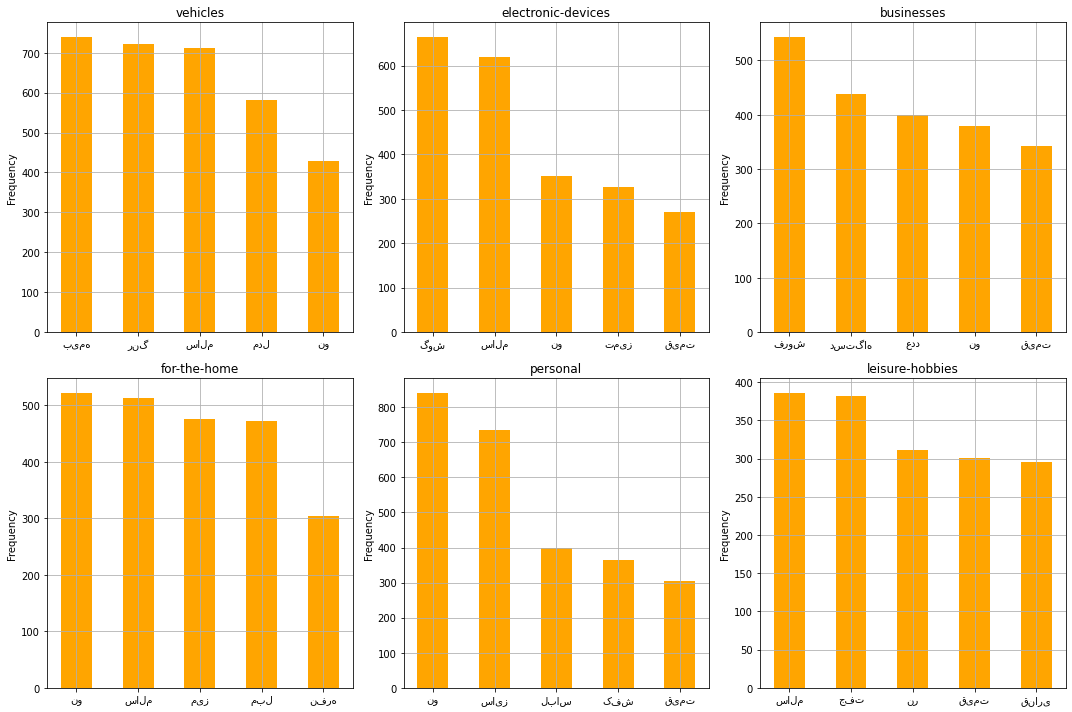

In [5]:
import matplotlib.pyplot as plot

calculate_frequency(train_data)

plot.figure(figsize=(15,10))

for i in range(6):
    plot.subplot(2, 3, i + 1)
    sort = sorted(frequency[i].items(), key=lambda x: x[1], reverse=True)
    most_freq = sort[0:5]
    cat = []
    values = []
    for item in most_freq:
        cat.append(item[0])
        values.append(item[1])

    plot.bar(cat, values, color='orange', width=0.5)
    plot.ylabel('Frequency')
    plot.title(category[i])
    plot.grid()

plot.tight_layout()
plot.show()

## Evaluation

Now we use classify function that we written before to predict category of our test dataset, then use evaluate function
to compare predicted category with real mentioned category and calculate evaluation parameters.

7 -
* Precision : This parameter defines ratio of count of prediction of category c to actual count of actual data in
category c.
* Recall : Ratio of correct prediction of system for category c.

For example if we predict all ads are business we have hight recall value but our system not working correct.

On the other hand if our system is very definite that some ad is in category business we have high precision. In this
case we might miss predict many ads or only predict business category and place other ads in other categories.

8 - F1 uses harmonic mean wich is a kind of geometric mean and it's also dependent on FP and FN so it's good benchmark.

9 -
* Macro : In macro-F1 we average from 6 values of 6 categories.
* Micro : We consider all data together. micro-f1 = micro-precision = micro-recall = accuracy
* Weighted : Depending on the number of parameters, we assign a weight to each value. Find the number of classes and
multiply by corresponding F1, then divide the sum of the obtained values by the total number.

10 -
A) Fro additive smothing we set $\alpha = 0.2$

In [6]:
def evaluate(test_):
    correct_detected = 0
    total = len(test_)
    precision = [0.0] * len(category)
    recall = [0.0] * len(category)
    f_1 = [0.0] * len(category)
    correct_detected_class = [0] * len(category)
    all_detected_class = [0] * len(category)
    total_class = [0] * len(category)

    counter = 0
    x = []

    for ads in range(len(test_)):
        if test_['categories'][ads] == test_['predicted'][ads]:
            correct_detected += 1
        elif counter < 5:
            counter += 1
            x.append(ads)
        for i in range(len(category)):
            if test_['predicted'][ads] == category[i] and test_['categories'][ads] == category[i]:
                correct_detected_class[i] += 1
            if test_['predicted'][ads] == category[i]:
                all_detected_class[i] += 1
            if test_['categories'][ads] == category[i]:
                total_class[i] += 1

    accuracy = correct_detected / total * 100
    macro_f1 = 0
    for i in range(len(category)):
        precision[i] = (correct_detected_class[i] / all_detected_class[i]) * 100
        recall[i] = (correct_detected_class[i] / total_class[i]) * 100
        f_1[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
        macro_f1 += f_1[i]
        print(category[i], ': Precision = ', precision[i], ' Recall = ', recall[i], ' F1 = ', f_1[i])
    print("Accuracy = ", accuracy)
    print("macroF1 = ", macro_f1 / 6)
    return x


classify(test, alpha=0.2)
test['predicted'] = prediction
ev_additive = evaluate(test)

vehicles : Precision =  90.81967213114754  Recall =  92.33333333333333  F1 =  91.57024793388429
electronic-devices : Precision =  90.84967320261438  Recall =  92.66666666666666  F1 =  91.74917491749174
businesses : Precision =  77.491961414791  Recall =  80.33333333333333  F1 =  78.88707037643206
for-the-home : Precision =  85.23489932885906  Recall =  84.66666666666667  F1 =  84.94983277591973
personal : Precision =  88.23529411764706  Recall =  90.0  F1 =  89.1089108910891
leisure-hobbies : Precision =  92.7007299270073  Recall =  84.66666666666667  F1 =  88.50174216027875
Accuracy =  87.44444444444444
macroF1 =  87.46116317584926


B) As we mentioned before if we set $\alpha = 0$ we get same result as we didn't applied additive smoothing.

In [7]:
prediction = []

classify(test, alpha=0)
test['predicted'] = prediction
ev = evaluate(test)

vehicles : Precision =  8.623298033282904  Recall =  19.0  F1 =  11.86264308012487
electronic-devices : Precision =  8.786610878661087  Recall =  7.000000000000001  F1 =  7.792207792207793
businesses : Precision =  17.341040462427745  Recall =  10.0  F1 =  12.684989429175475
for-the-home : Precision =  7.78816199376947  Recall =  8.333333333333332  F1 =  8.051529790660224
personal : Precision =  12.213740458015266  Recall =  10.666666666666668  F1 =  11.387900355871887
leisure-hobbies : Precision =  19.444444444444446  Recall =  9.333333333333334  F1 =  12.612612612612615
Accuracy =  10.722222222222221
macroF1 =  10.731980510108812


11 - We can clearly see by applying additive smoothing we get much higher accuracy.

12 - Here are 5 ads that we predict incorrectly.

In [8]:
for ad in ev_additive:
    title = test['title'][ad]
    description = test['description'][ad]
    cat_ = test['categories'][ad]
    predict = test['predicted'][ad]
    print(f'{ad} : Title = {title} | Description = {description} | Category = {cat_} | Predict = {predict}')

16 : Title = ['سیپوراکس'] | Description = ['سیپوراکس', 'میکرو', 'مک', 'جی', 'ال', 'سرامیک', 'سرا', 'کاهنده', 'نیترات', 'نیتریت', 'اکواریوم', 'درجه'] | Category = leisure-hobbies | Predict = businesses
27 : Title = ['عینک', 'آفتاب'] | Description = ['عینک', 'آفتاب', '١٠٠', '٪\u200f', 'UV', 'Protection'] | Category = personal | Predict = vehicles
28 : Title = ['موتور', 'تزیین'] | Description = ['جنس', 'اهن', 'کار', 'دست', 'عرضه', 'صورت', 'عمده', 'تک'] | Category = for-the-home | Predict = personal
49 : Title = ['اچارشلاقی', 'HEYCOالمان'] | Description = ['اصل', 'المان', 'سایز', '۱/۵', 'مقاوم'] | Category = businesses | Predict = electronic-devices
50 : Title = ['فروش', 'تلفکس'] | Description = ['سلام', 'تلفکس', 'پاناسونیک', 'تمیز', 'کار'] | Category = businesses | Predict = businesses
